# Tensorflow 2.0 

Check Tensorflow installation

In [1]:
import tensorflow as tf
print(tf.version)

2023-04-29 11:25:04.747666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 11:25:07.453684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'tensorflow._api.v2.version' from '/home/phanxv/miniconda3/envs/ML/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

### Creating Tensor
A tensor is a generalization of vectors and matrices to potentially higher dimensions. Internally, TensorFlow represents tensors as n-dimensional arrays of base datatypes.

Creating Scalar (RANK 0 tensor)

In [ ]:
tensor_string = tf.Variable("This is a tensor string", tf.string)
tensor_int = tf.Variable(420, tf.int16)
tensor_float = tf.Variable(69.420, tf.float32)

Creating Vectors/Matrices (RANK >0 tensor)

In [ ]:
rank1_tensor = tf.Variable([69,420], tf.int16)
rank2_tensor = tf.Variable([[49,420],[9,11]], tf.int16)

In [ ]:
tf.rank(rank2_tensor)

In [ ]:
rank2_tensor.shape

Changing shape of a tensor

In [ ]:
tensor1 = tf.ones([2,2,3])
print(tensor1)
tensor2 = tf.reshape(tensor1,[2,3,2])
print(tensor2)
tensor3 = tf.reshape(tensor1,[12])
print(tensor3)

# TensorFlow Core Learning Algorithms

## Linear Regression
Linear regression is one of the most basic forms of machine learning and is used to predict numeric values.

Use when the datapoint is correlated linearly

Example of Data for linear regression

In [ ]:
x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])

Line of best fit for this example.

In [ ]:
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

Creating Model to predicting the Line of best fit

Load Dataset

- Titanic dataset contain list and attribute of people boarding Titanic at the time of the crash

In [3]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [4]:
dftrain.pop('n_siblings_spouses')
dftrain.pop('fare')
dftrain.head()

,sex,age,parch,class,deck,embark_town,alone
0,male,22.0,0,Third,unknown,Southampton,n
1,female,38.0,0,First,C,Cherbourg,n
2,female,26.0,0,Third,unknown,Southampton,y
3,female,35.0,0,First,C,Southampton,n
4,male,28.0,0,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,parch
count,627.000000,627.000000
mean,29.631308,0.379585
std,12.511818,0.792999
min,0.750000,0.000000
25%,23.000000,0.000000
50%,28.000000,0.000000
75%,35.000000,0.000000
max,80.000000,5.000000


<Axes: >

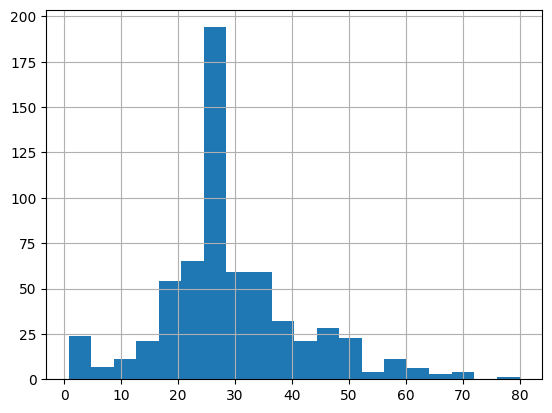

In [6]:
dftrain.age.hist(bins=20)

In [ ]:
dftrain.sex.value_counts().plot(kind="barh")

Text(0.5, 0, '% survive')

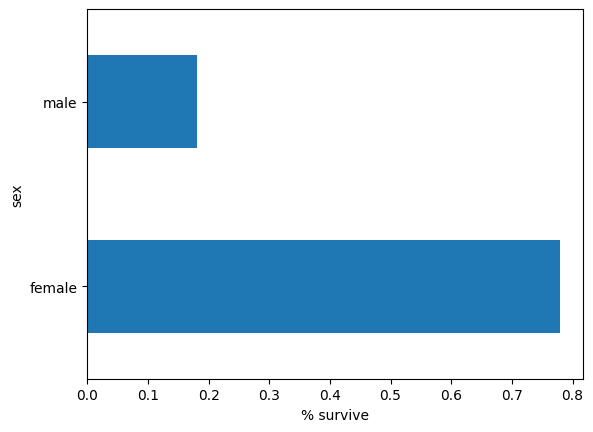

In [7]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

Encoding categorical and numeric data into tensor

In [8]:
CATEGORICAL_COLUMNS  = ['sex','parch','class','deck','embark_town','alone']
NUMERICAL_COLUMNS = ['age']

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERICAL_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

feature_columns

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Training Process
Load small amount of data (batches) into the model using input function

In [9]:
def make_input_fn(data_df, label_df, num_epochs=16, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

### Creating a model

In [10]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8s8mez1w', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster'

### Training a model

In [13]:
linear_est.train(train_input_fn)  # train
#result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data
#clear_output()  # clears consoke output
#print(result)  # the result variable is simply a dict of stats about our model

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8s8mez1w/model.ckpt-320
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-04-21 19:16:47.491219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-21 19:16:47.491476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-21 19:16:47.491599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-21 19:16:47.492139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-21 19:16:47.492175: I tensorflow/core/co

INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 320...
INFO:tensorflow:Saving checkpoints for 320 into /tmp/tmp8s8mez1w/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 320...


2023-04-21 19:16:48.178349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [627]
	 [[{{node Placeholder/_0}}]]
2023-04-21 19:16:48.178871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [627]
	 [[{{node Placeholder/_4}}]]


INFO:tensorflow:loss = 0.4296071, step = 320
INFO:tensorflow:global_step/sec: 35.6281
INFO:tensorflow:loss = 0.40307096, step = 420 (2.808 sec)
INFO:tensorflow:global_step/sec: 36.7174
INFO:tensorflow:loss = 0.32108542, step = 520 (2.724 sec)
INFO:tensorflow:global_step/sec: 36.8733
INFO:tensorflow:loss = 0.25441793, step = 620 (2.711 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 640...
INFO:tensorflow:Saving checkpoints for 640 into /tmp/tmp8s8mez1w/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 640...
INFO:tensorflow:Loss for final step: 0.48207292.


In [14]:
result = list(linear_est.predict(eval_input_fn))
correct = 0
incorrect = 0

for i in range(len(result)) :
    print(y_eval.loc[i])
    print(result[i]["probabilities"][1])
    if y_eval.loc[i] == round(result[i]["probabilities"][1]) :
        correct += 1
    else :
        incorrect += 1

accuracy = (correct / (correct + incorrect)) * 100
print("CORRECT PREDICTION : " + str(correct) + '/' + str(correct+incorrect))
print("INCORRECT PREDICTION : " + str(incorrect) + '/' + str(correct+incorrect))
print("ACCURACY : " + str(accuracy) + "%")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8s8mez1w/model.ckpt-640
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-04-21 19:17:15.767015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-21 19:17:15.767201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-21 19:17:15.767282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-21 19:17:15.767743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-21 19:17:15.767788: I tensorflow/core/co

0
0.06928074
0
0.4848546
1
0.79747564
1
0.6513421
1
0.2762175
1
0.7689809
0
0.76602006
0
0.102683336
0
0.68298715
1
0.74643713
1
0.6906693
0
0.102683336
1
0.85346645
0
0.5084452
1
0.87733454
0
0.62157017
0
0.14368503
1
0.8571936
1
0.5761004
0
0.082149655
0
0.10554827
0
0.061799813
1
0.67729235
0
0.06356957
0
0.669539
0
0.71631396
0
0.2131938
0
0.34388605
1
0.20505694
1
0.84784436
0
0.12630211
1
0.79536974
0
0.20380601
1
0.6418114
0
0.24359427
1
0.0869023
0
0.17210479
0
0.13183208
1
0.91761804
0
0.07986312
1
0.7475697
1
0.09994092
0
0.3236823
0
0.36157948
0
0.27342585
1
0.8023408
0
0.102683336
0
0.39400086
1
0.4909203
0
0.456917
0
0.08097574
0
0.23534453
0
0.059105553
0
0.08964187
1
0.11149018
0
0.09449819
0
0.18001334
1
0.9705696
0
0.19401848
0
0.08449567
1
0.27087942
1
0.6972213
0
0.20883572
1
0.84156275
0
0.18459202
0
0.64987504
1
0.4690789
0
0.08952671
0
0.1595754
1
0.6680109
1
0.94705075
0
0.5115314
0
0.037601735
1
0.108483516
0
0.12630211
1
0.07986312
0
0.0998875
1
0.13183208
1
0.

## Classification

- Dataset is Iris which is the daataset containing a different species of flower

- load dataset

In [9]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

In [10]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [11]:
train_y = train.pop('Species')
test_y = test.pop('Species')

In [12]:
train_y.head()
train.shape

(120, 4)

Creating input function

In [13]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)


In [14]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [15]:
my_feature_columns

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Building Model
- DNNClassifier

In [16]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[50, 30],
    # The model must choose between 3 classes.
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\phank\\AppData\\Local\\Temp\\tmp4_xl7co4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Training a model

In [17]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# We include a lambda to avoid creating an inner function previously

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\phank\AppData\Local\Temp\tmp4_xl7co4\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.2308007, step = 0
INFO:tensorflow:global_step/sec: 175.605
INFO:tensorflow:loss = 0.94507265, step = 100 (0.571 sec)
INFO:tensorflow:global_step/sec: 207.853
INFO:tensorflow:loss = 0.84087837, step = 200 (0.481 sec)
INFO:tensorflow:global_step/sec: 204.035
INFO:tensorflow:loss = 0.78121346, step = 300 (0.490 sec)
INFO:tensorflow:global_step/sec: 208.721
INFO:tensor

Evaluating modeel

In [18]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-03-18T14:07:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\phank\AppData\Local\Temp\tmp4_xl7co4\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.84942s
INFO:tensorflow:Finished evaluation at 2023-03-18-14:07:18
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.96666664, average_loss = 0.2567342, global_step = 5000, loss = 0.2567342
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: C:\Users\phank\AppData\Local\Temp\tmp4_xl7co4\model.ckpt-5000

Test set accuracy: 0.967



Predicting using trained model

In [21]:
input_feature_columns = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

def usr_input_fn(features, batch_size=256):
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

print("user input")
for feature in input_feature_columns :
    val = input(feature + ' >> ')
    predict[feature] = [float(val)]

print('user input object : ' + str(predict))
predictions = classifier.predict(input_fn=lambda: usr_input_fn(predict))

for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    prob = pred_dict['probabilities'][class_id]
    print('Prediction is "{}" ({:.1f}%)'.format(SPECIES[class_id], 100*prob))


user input
user input object : {'SepalLength': [5.0], 'SepalWidth': [2.3], 'PetalLength': [3.3], 'PetalWidth': [1.0]}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\phank\AppData\Local\Temp\tmp4_xl7co4\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Versicolor" (75.4%)


### Hidden Markov Model

finite set of state associated with a probability distribution useful for predicting future event based on past event

States : Could be anything

Observation : Each state will have a particular outcome or observation associated with it

Transitions : Each state will have a probability to transition to a different state

In [4]:
import tensorflow_probability as tfp
import tensorflow as tf

Example Data : Weather model
1. Cold days are encoded by a 0 and hot days are encoded by a 1.
2. The first day in our sequence has an 80% chance of being cold.
3. A cold day has a 30% chance of being followed by a hot day.
4. A hot day has a 20% chance of being followed by a cold day.
5. On each day the temperature is
 normally distributed with mean and standard deviation 0 and 5 on
 a cold day and mean and standard deviation 15 and 10 on a hot day.

In [16]:
tfd = tfp.distributions
initial_distribution = tfd.Categorical(probs=[0.8, 0.2]) 
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])

In [17]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7) #how many time to step through probability

In [18]:
mean = model.mean()

with tf.compat.v1.Session() as sess:
    print(mean.numpy())

[3.        6.        7.4999995 8.249999  8.625001  8.812501  8.90625  ]


2023-04-29 11:39:05.080956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 11:39:05.081131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 11:39:05.081201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 11:39:05.081576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 11:39:05.081607: I tensorflow/core/co

## Neural Network with Tensorflow

### import

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

### Dataset
MNIST Fashion Dataset
This dataset includes 60,000 images for training and 10,000 images for validation/testing.

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
fashion_train_images.shape

(60000, 28, 28)

In [42]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

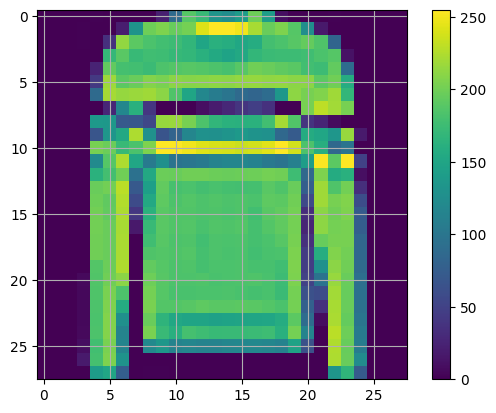

In [6]:
plt.figure()
plt.imshow(fashion_train_images[5])
plt.colorbar()
plt.grid(True)
plt.show()

### Data preprocessing

In [44]:
fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0

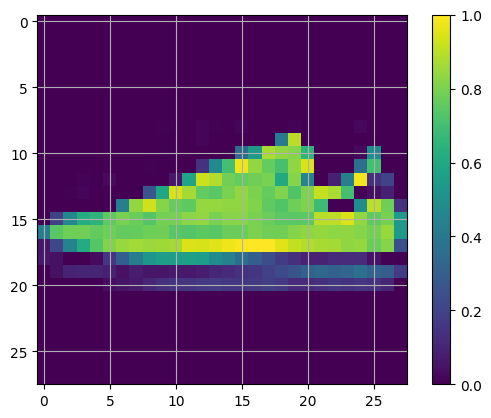

In [49]:
plt.figure()
plt.imshow(fashion_train_images[6])
plt.colorbar()
plt.grid(True)
plt.show()

### Building Model


In [61]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # input layer (1) flatten 28x28 pixel grid to 784 value
    keras.layers.Dense(256, activation='relu'),  # hidden layer (2) 128 Neurons Densly connected using ReLu as activation function
    keras.layers.Dense(10, activation='softmax') # output layer (3) 10 Output nueron for 10 output classes
])

### Compiling the model

In [62]:
model.compile(optimizer='adam', #performing gradient decent 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### passing or fitting the data to the model 

In [69]:
model.fit(fashion_train_images, fashion_train_labels, epochs=8, batch_size=64)

Epoch 1/8
938/938 [==============================] - 5s 5ms/step - loss: 0.1278 - accuracy: 0.9520
Epoch 2/8
938/938 [==============================] - 5s 5ms/step - loss: 0.1226 - accuracy: 0.9542
Epoch 3/8
938/938 [==============================] - 5s 5ms/step - loss: 0.1242 - accuracy: 0.9534
Epoch 4/8
938/938 [==============================] - 5s 5ms/step - loss: 0.1254 - accuracy: 0.9528
Epoch 5/8
938/938 [==============================] - 5s 5ms/step - loss: 0.1209 - accuracy: 0.9543
Epoch 6/8
938/938 [==============================] - 5s 5ms/step - loss: 0.1157 - accuracy: 0.9576
Epoch 7/8
938/938 [==============================] - 5s 5ms/step - loss: 0.1159 - accuracy: 0.9561
Epoch 8/8
938/938 [==============================] - 5s 5ms/step - loss: 0.1115 - accuracy: 0.9579


### Evaluating Model

In [70]:
test_loss, test_acc = model.evaluate(fashion_test_images, fashion_test_labels, verbose=1)

print("Test Accuracy : ", test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.4159 - accuracy: 0.8923
Test Accuracy :  0.892300009727478
